### Laboratorio de Escalonamento ###

Neste laboratório, iremos simular o funcionamento de algoritmos de escalonamento básicos para entender melhor seu funcionamento.

Na célula abaixo, temos uma classe Processo, que tem as informações de execução, e uma classe de exemplo de escalonamento apenas com os protótipos:

(orientação a objeto em Python)

In [1]:
import numpy as np
import random
from copy import deepcopy

class Processo(object):
    def __init__(self, pnome, pio, ptam, prioridade, tempoChegada):
        self.nome = pnome
        self.io = pio # Probabilidade de fazer E/S, inicialmente zero
        self.tam = ptam # Quantos Timeslices sao necessarios para terminar
        self.prio = prioridade # Prioridade, é desnecessaria agora 
        self.chegada = tempoChegada

    def roda(self, quantum=None):
        if(random.randint(1, 100) < self.io):
            self.tam -= 1
            print(self.nome," fez e/s, falta ", self.tam)
            return 1, True
            
            
        if(quantum is None or self.tam < quantum):
            quantum = self.tam
        
        self.tam -= quantum
#         print(self.nome," rodou por ", quantum, " timeslice, faltam ", self.tam)
        return quantum, False

class escalonadorFIFO(object):
    name = "EscalonadorFIFO"
    def __init__(self, vprontos = []):
        self.prontos = vprontos
       
        
    def pronto(self,Processo):
        self.prontos.append(Processo)
    
    def proximo(self):
        p =  self.prontos.pop(0)
        return p

class escalonadorSJF(object):
    name = "EscalonadorSJF"
    def __init__(self, vprontos = []):
        self.prontos = vprontos

    def pronto(self,Processo):
        self.prontos.append(Processo)
        
    def proximo(self):
        minIndex = self.getMin()
        p =  self.prontos.pop(minIndex)
        return p
    
    def getMin(self):
        minIndex = 0
        minTam = 0x3f3f3f
        for (idx, item) in enumerate(self.prontos):
            if (item.tam < minTam):
                minIndex = idx
                minTam = item.tam
        
        return minIndex

class escalonadorSTCF(object):
    name = "EscalonadorSTCF"
    def __init__(self,vprontos = []):
        self.prontos = vprontos

    def pronto(self, Processo):
        self.prontos.append(Processo)
        
    def proximo(self):
        p =  self.prontos.pop(0)
        return p

class escalonadorRoundRobin(object):
    name = "EscalonadorRoundRobin"
    def __init__(self,vprontos = []):
        self.prontos = vprontos

    def pronto(self, Processo):
        self.prontos.append(Processo)
        
    def proximo(self):
        p =  self.prontos.pop(0)
        return p

Na célula abaixo, são criados quatro processos completamente CPU-Bound que precisam de 3 timeslices para rodar.

O valor de E/S é um número entre 0 e 100 indicando quantos porcento de chance o processo tem de fazer E/S durante seu tempo na CPU

In [4]:
nomes = ['A','B','C']
chance_io = [0, 0, 0, 0, 0, 0] #Valor de zero a cem, chance de ser entrada e saida por enquanto deixem em zero
tamanho = np.array([5, 5, 5])
nprocs = len(nomes)

total = tamanho.sum()
print(total)

procs = []
for i in range(nprocs):
    procs.append(Processo(nomes[i],chance_io[i],tamanho[i], 0, 0)) #cria uma lista procs de Processos

15


Na célula abaixo, temos uma simulação do funcionamento de um escalonador de processos. As duas configurações importantes aqui são o valor do quantum padrão (que pode ser dinamico em algoritmos mais complexos, e quantos timeslices um processo que faz e/s passa bloqueado.

Percebam que na terceira linha é instanciado o escalonador (neste caso, um round_robin). Isto foi feito assim para ser simples trocar o escalonador e repetir a simulação, bastando criar uma classe com os métodos pronto, proximo e construtor e alterar esta linha.

In [5]:
def run_simple(escalonador, total):
        
    tempo = 0
    t_exec = 0
    t_wait = 0
    t_exec_m = 0
    
    while total > 0:
        p = escalonador.proximo()
        if(p is not None):
            rodou, _ = p.roda()

            if(p.tam > 0):
                escalonador.pronto(p)
            
            t_wait += tempo - p.chegada
            
            total -= rodou
            tempo += rodou

            t_exec += (rodou - p.chegada)
            t_exec_m += t_exec

        else:
            tempo+=1
    
    print(escalonador.name, "Tempo de Execução: ", t_exec_m / nprocs, "Tempo de Resposta: ", t_wait / nprocs)
    return t_wait / nprocs
    
quantum = 2
tempoBloq = 1
bloqueados = []
random.seed(0)

procs2 = deepcopy(procs)

escalonador_FIFO = escalonadorFIFO(procs)
escalonador_SJF = escalonadorSJF(procs2)

run_simple(escalonador_FIFO, total)
run_simple(escalonador_SJF, total)

EscalonadorFIFO Tempo de Execução:  10.0 Tempo de Resposta:  5.0
EscalonadorSJF Tempo de Execução:  10.0 Tempo de Resposta:  5.0


5.0

In [3]:
nomes = ['A','B','C']
chance_io = [0, 0, 0, 0] #Valor de zero a cem, chance de ser entrada e saida por enquanto deixem em zero
tamanho = np.array([5, 5, 5])
tempoChegada = np.array([0, 0, 0, 0])
nprocs = len(nomes)

total = tamanho.sum()

procs = []
for i in range(nprocs):
    procs.append(Processo(nomes[i], chance_io[i], tamanho[i], 0, tempoChegada[i])) #cria uma lista procs de Processos

procs2 = deepcopy(procs)
escalonador = escalonadorSTCF(procs)
escalonador2 = escalonadorRoundRobin(procs2)

def run(escalonador, total, quantum = None):
    
    tempo = 0
    t_exec_m = 0
    t_wait_m = 0
    t_wait_dict = {nome:[0, False] for nome in nomes}
    
    while total > 0:
        p = escalonador.proximo()
        if(p is not None):
            rodou, _ = p.roda(quantum)
            
            if (t_wait_dict[p.nome][1] == False):
                t_wait_dict[p.nome][0] = tempo
                t_wait_dict[p.nome][1] = True
            
            tempo += rodou
            if(p.tam > 0):
                escalonador.pronto(p)
            else:
                t_exec_m += tempo
            
            total -= rodou

        else:
            tempo += 1
            
    for value in t_wait_dict.values():
        t_wait_m += value[0]
    
    print(escalonador.name, "Tempo de Execução: ", t_exec_m / nprocs, "Tempo de Resposta: ", t_wait_m / nprocs)
    return t_wait_m / nprocs

run(escalonador, total, 5)
run(escalonador2, total, 5)

EscalonadorSJF Tempo de Execução:  20.0 Tempo de Resposta:  10.0
EscalonadorSJF Tempo de Execução:  30.0 Tempo de Resposta:  15.0
EscalonadorSJF Tempo de Execução:  40.0 Tempo de Resposta:  20.0
EscalonadorSJF Tempo de Execução:  50.0 Tempo de Resposta:  25.0
EscalonadorSJF Tempo de Execução:  60.0 Tempo de Resposta:  30.0
EscalonadorSJF Tempo de Execução:  70.0 Tempo de Resposta:  35.0
EscalonadorSJF Tempo de Execução:  80.0 Tempo de Resposta:  40.0
EscalonadorSJF Tempo de Execução:  90.0 Tempo de Resposta:  45.0
EscalonadorSJF Tempo de Execução:  100.0 Tempo de Resposta:  50.0


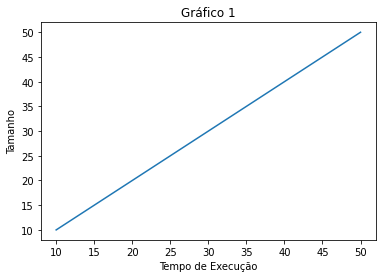


EscalonadorRoundRobin Tempo de Execução:  145.0 Tempo de Resposta:  5.0
EscalonadorRoundRobin Tempo de Execução:  148.0 Tempo de Resposta:  6.0
EscalonadorRoundRobin Tempo de Execução:  148.0 Tempo de Resposta:  8.0
EscalonadorRoundRobin Tempo de Execução:  144.0 Tempo de Resposta:  11.0
EscalonadorRoundRobin Tempo de Execução:  145.0 Tempo de Resposta:  15.0
EscalonadorRoundRobin Tempo de Execução:  140.0 Tempo de Resposta:  20.0
EscalonadorRoundRobin Tempo de Execução:  126.0 Tempo de Resposta:  26.0
EscalonadorRoundRobin Tempo de Execução:  133.0 Tempo de Resposta:  33.0
EscalonadorRoundRobin Tempo de Execução:  141.0 Tempo de Resposta:  41.0
EscalonadorRoundRobin Tempo de Execução:  100.0 Tempo de Resposta:  50.0


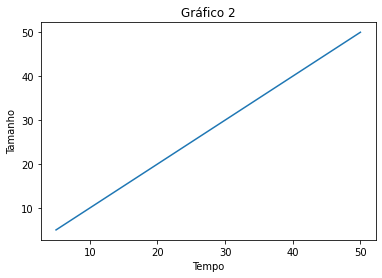

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

nomes = ['A','B','C']
chance_io = [0, 0, 0, 0] #Valor de zero a cem, chance de ser entrada e saida por enquanto deixem em zero
tempoChegada = np.array([0, 0, 0])
nprocs = len(nomes)
xAxis = []
yAxis = []

x = 5
for i in range(5, 50, 5):
    
    yAxis.append(x + i);
    tamanho = np.array([x + i, x + i, x + i])
    total = tamanho.sum()
    t_exec = 0
    procs = []
    for i in range(nprocs):
        procs.append(Processo(nomes[i], chance_io[i], tamanho[i], 0, tempoChegada[i]))
    
    t_exec = run_simple(escalonadorSJF(procs), total)
    xAxis.append(t_exec)

plt.plot(xAxis, yAxis)
plt.title('Gráfico 1')
plt.ylabel('Tamanho')
plt.xlabel('Tempo de Execução')
plt.show()
    
print()
quantum = 5

xAxis = []
yAxis = []

for i in range(10):
    
    quantum += i
    
    yAxis.append(quantum)
    tamanho = np.array([50, 50, 50])
    total = tamanho.sum()
    procs = []
    t_exec = 0
    for i in range(nprocs):
        procs.append(Processo(nomes[i], chance_io[i], tamanho[i], 0, tempoChegada[i]))
    
    t_exec = run(escalonadorRoundRobin(procs), total, quantum)
    xAxis.append(t_exec)
    
plt.plot(xAxis, yAxis)
plt.title('Gráfico 2')
plt.ylabel('Tamanho')
plt.xlabel('Tempo')
plt.show()

### Laboratório: ###


1 - Altere o simulador acima para calcular o tempo de execucao medio e tempo de resposta 

2 - Implemente o escalonador por FIFO e SJF e verifique seus tempos de execução e espera.

3 - Faça em outra célula uma implementação do STCF e Round Robin, alterando o p.roda() para receber o quantum


Na segunda feira (15) haverá um questionário no ColabWeb onde você deverá utilizar suas implementações para responder às perguntas. Na terça de manhã farei uma breve conferência para tirar dúvidas.